In [1]:
## Project: Action Recognition using CNN + LSTM (PyTorch)
import sys
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
# Project root: works when run from repo root or from notebooks/
try:
    PROJECT_ROOT = Path(__file__).resolve().parent.parent
except NameError:
    PROJECT_ROOT = Path.cwd() if (Path.cwd() / "src" / "vllmd").exists() else Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Make the package importable as "vllmd" (package lives under src/vllmd)
_src = PROJECT_ROOT / "src"
if _src.exists() and str(_src) not in sys.path:
    sys.path.insert(0, str(_src))

import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch  # pyright: ignore[reportMissingImports]
import torch.nn as nn  # pyright: ignore[reportMissingImports]
from torch.utils.data import DataLoader  # pyright: ignore[reportMissingImports]
from torch.optim import Adam  # pyright: ignore[reportMissingImports]
import torchvision.models as models  # pyright: ignore[reportMissingImports]
from vllmd.video_processing import VideoDataProcessor, VideoDataset, ActionRecognitionPipeline, describe_frames_after_predict_each_frame

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# Paths relative to project root (use data/ for datasets)
DIRECTORY = PROJECT_ROOT / "data" / "abnormal"
NORMAL_DIRECTORY = PROJECT_ROOT / "data" / "normal"
PATH_VIDEO_TEST = PROJECT_ROOT / "data" / "test" / "19.mp4"
RULE_PATH = PROJECT_ROOT / "data" / "rules" / "entity_rules.txt"
PATH_MODEL = PROJECT_ROOT / "models" / "best_model.pt"
RESULTS_DIR = PROJECT_ROOT / "results"

# Create results folder for all outputs (figures, CSVs, etc.)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

DIRECTORY = str(DIRECTORY)
NORMAL_DIRECTORY = str(NORMAL_DIRECTORY)
PATH_VIDEO_TEST = str(PATH_VIDEO_TEST)
RULE_PATH = str(RULE_PATH)
PATH_MODEL = str(PATH_MODEL)

processor = VideoDataProcessor(DIRECTORY, NORMAL_DIRECTORY, frame_size=64, num_frames=40)
selected_classes = processor.selected_classes
Frame_Size = processor.frame_size
print(selected_classes)

['Arrest', 'Attack', 'Burglary', 'Explosion', 'Fighting', 'fire-raising', 'Ill-treatment', 'Traffic Irregularities', 'violence', 'Normal Videos']


In [3]:
train_df = processor.build_dataframe()
print(train_df.head())

                                          video_path   label
0  c:\Users\thier\OneDrive\Bureau\Workspace\Thesi...  Arrest
1  c:\Users\thier\OneDrive\Bureau\Workspace\Thesi...  Arrest
2  c:\Users\thier\OneDrive\Bureau\Workspace\Thesi...  Arrest
3  c:\Users\thier\OneDrive\Bureau\Workspace\Thesi...  Arrest
4  c:\Users\thier\OneDrive\Bureau\Workspace\Thesi...  Arrest


In [4]:
# Saving original frame without any resizing
from PIL import Image

for class_index, cls in enumerate(selected_classes):
    if cls == "Normal Videos":
        class_path = os.path.join(NORMAL_DIRECTORY, cls)
        videos = os.listdir(class_path)[:30]
    else:
        class_path = os.path.join(DIRECTORY, cls)
        videos = os.listdir(class_path)[:30]
    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = processor.extract_original_frames(video_path, num_frames=40)
        a = frames.shape

In [5]:
X_train, X_test, y_train, y_test = processor.load_training_arrays(videos_per_class=30, test_size=0.2, random_state=42)
print("Training:", len(X_train), "Testing:", len(X_test))

Training: 223 Testing: 56


In [6]:
train_dataset = VideoDataset(X_train, y_train)
val_dataset = VideoDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [7]:
num_classes = len(selected_classes)
pipeline = ActionRecognitionPipeline(num_classes, device, frame_size=Frame_Size, num_frames=40)
model = pipeline.model

In [8]:
history = pipeline.train(train_loader, val_loader, epochs=50, save_path=str(PATH_MODEL))

Epoch 1/50  train_loss=2.3043  train_acc=0.0987  val_loss=2.2754  val_acc=0.1607
Epoch 2/50  train_loss=2.2549  train_acc=0.1435  val_loss=2.2653  val_acc=0.1429
Epoch 3/50  train_loss=2.1436  train_acc=0.2422  val_loss=2.2169  val_acc=0.2143
Epoch 4/50  train_loss=2.0029  train_acc=0.2511  val_loss=2.3310  val_acc=0.1250
Epoch 5/50  train_loss=1.8844  train_acc=0.3184  val_loss=2.2537  val_acc=0.1964
Epoch 6/50  train_loss=1.8646  train_acc=0.2915  val_loss=2.3546  val_acc=0.1250
Epoch 7/50  train_loss=1.8216  train_acc=0.2825  val_loss=2.3437  val_acc=0.1250
Epoch 8/50  train_loss=1.7032  train_acc=0.3274  val_loss=2.2048  val_acc=0.1786
Epoch 9/50  train_loss=1.6845  train_acc=0.3453  val_loss=2.3600  val_acc=0.1786
Epoch 10/50  train_loss=1.6734  train_acc=0.3587  val_loss=2.5467  val_acc=0.1429
Epoch 11/50  train_loss=1.6390  train_acc=0.3991  val_loss=2.4253  val_acc=0.1429
Epoch 12/50  train_loss=1.5339  train_acc=0.4350  val_loss=2.6990  val_acc=0.1250
Epoch 13/50  train_loss=1

In [9]:
pipeline.load(str(PATH_MODEL))
# pipeline.show_predictions(X_test, y_test, selected_classes, num_samples=5)

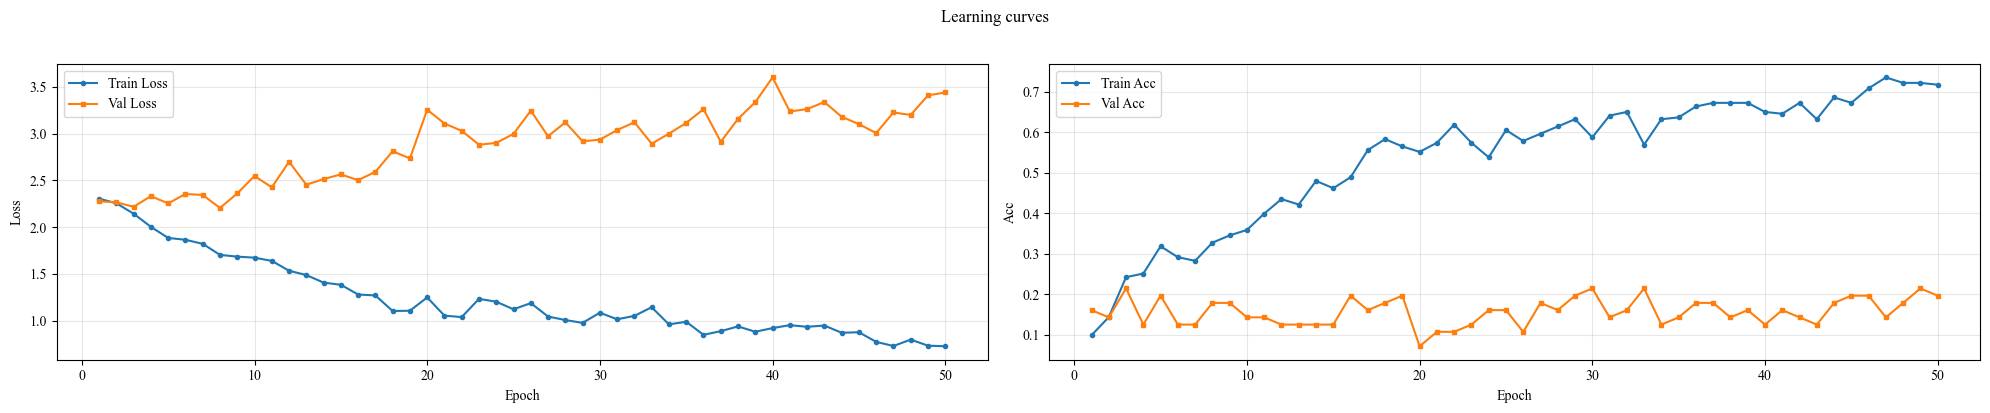

In [10]:
# Show learning curves and save to results folder
import json
from vllmd.utils import plot_learning_curves

# Save training history (numeric results) for later use
if isinstance(history, dict):
    with open(RESULTS_DIR / "training_history.json", "w") as f:
        json.dump({k: [float(x) for x in v] for k, v in history.items()}, f, indent=2)

fig = plot_learning_curves(
    history,
    title="Learning curves",
    save_path=str(RESULTS_DIR / "learning_curves.png"),
)
plt.show()

In [11]:
# Run prediction on test video to get frame_indices, frames, frames_original
frame_indices, preds, probs, frames, frames_original = pipeline.predict_each_frame(
    str(PATH_VIDEO_TEST), processor, selected_classes
)

In [13]:
# Save prediction results to results folder
import pandas as pd
pred_df = pd.DataFrame({
    "frame_index": frame_indices,
    "predicted_class": preds,
    "predicted_idx": [selected_classes.index(p) for p in preds],
})
pred_df.to_csv(RESULTS_DIR / "predictions.csv", index=False)
if probs is not None:
    np.savez(RESULTS_DIR / "prediction_probs.npz", frame_indices=frame_indices, preds=preds, probs=probs)
print(f"Saved predictions to {RESULTS_DIR}")

Saved predictions to c:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\results


In [14]:
# External API image description (5 LLM models: OpenAI, Anthropic, Google)
from vllmd.llm import ExternalLLMImageDescriber, MODEL_NAMES
describer = ExternalLLMImageDescriber(
    default_model="gemini-3-flash-preview",  # "gemini-2.0-flash", "gemini-3-pro-preview", "gemini-3-flash-preview" , "gemini-2.5-flash".
)

# Describe a few predicted frames with the external API (uses frames from cell above)
num_frames_to_describe = 4
show_indices = np.linspace(0, len(frame_indices) - 1, min(num_frames_to_describe, len(frame_indices)), dtype=int)
frames_to_describe = [frames_original[i] if frames_original is not None else frames[i] for i in show_indices]

external_descriptions = []
for i, frame in enumerate(frames_to_describe):
    desc = describer.describe_frame(frame, prompt="Describe this video frame in 5 short sentences.")
    external_descriptions.append(desc)
    print(f"Frame {frame_indices[show_indices[i]]} [{describer.default_model}]: {desc}")
    #print()

Frame 39 [gemini-3-flash-preview]: A small group of people is standing together on a city street at night. One woman in a red dress reaches her arm out toward a man in dark clothing. Another woman stands nearby in a dark top and skirt, looking on. Yellow traffic lines are visible on the pavement behind the group. The grainy image suggests it was captured from a low-resolution video source.
Frame 125 [gemini-3-flash-preview]: A group of people are gathered on a street at night. A man in a dark jacket is at the center of a tense situation. Several women are surrounding him, and some appear to be pushing or pulling. One woman in a polka-dot top stands behind the man while others engage with him. The scene takes place outdoors next to a large parked vehicle.
Frame 212 [gemini-3-flash-preview]: A group of people are involved in a physical fight on a street at night. One woman in a black dress is pulling the hair of another woman on the ground. A man in a black jacket stands amidst the strug

Image,Description
,"Frame 39A small group of people is standing together on a city street at night. One woman in a red dress reaches her arm out toward a man in dark clothing. Another woman stands nearby in a dark top and skirt, looking on. Yellow traffic lines are visible on the pavement behind the group. The grainy image suggests it was captured from a low-resolution video source."
,"Frame 125A group of people are gathered on a street at night. A man in a dark jacket is at the center of a tense situation. Several women are surrounding him, and some appear to be pushing or pulling. One woman in a polka-dot top stands behind the man while others engage with him. The scene takes place outdoors next to a large parked vehicle."
,"Frame 212A group of people are involved in a physical fight on a street at night. One woman in a black dress is pulling the hair of another woman on the ground. A man in a black jacket stands amidst the struggling women. Other women nearby watch the altercation unfold. The scene takes place on a dark, paved road next to a vehicle."
,"Frame 299A person lies on the paved ground at night. A woman in a short skirt stands nearby, looking down at them. A man in a black jacket stands in the background watching the scene. Long shadows stretch across the ground from overhead streetlights. Several other bystanders are walking in the distance."

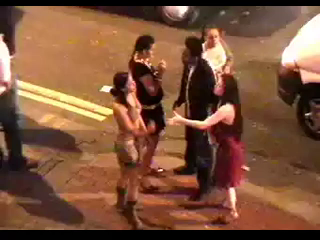
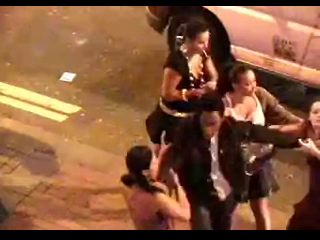
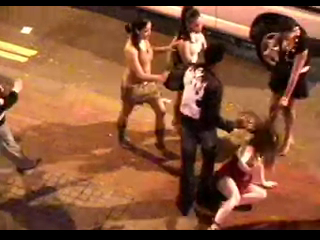
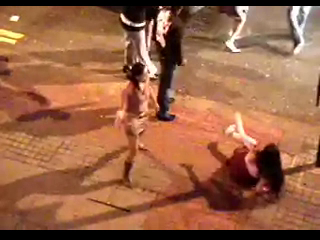

In [15]:
# Display each described frame and its description in a two-column table
from vllmd.utils import display_frames_with_descriptions

display_frames_with_descriptions(
    frames_to_describe,
    external_descriptions,
    frame_indices=[frame_indices[show_indices[i]] for i in range(len(frames_to_describe))],
)

In [16]:
# Custom entity extraction on frame descriptions (regex + keywords)
from vllmd.utils import load_rules_from_file
custom = load_rules_from_file(RULE_PATH, merge_overlaps=True)

custom_entities_per_frame = custom.extract_batch(external_descriptions, merge_duplicates=True)

print("Custom entities per frame description (ACTION / OBJECT / SCENE):")
for i, (desc, entities) in enumerate(zip(external_descriptions, custom_entities_per_frame)):
    print(f"\nFrame {i}: {desc}")
    if entities:
        print(f"  -> {[str(e) for e in entities]}")
    else:
        print("  -> (none)")

Custom entities per frame description (ACTION / OBJECT / SCENE):

Frame 0: A small group of people is standing together on a city street at night. One woman in a red dress reaches her arm out toward a man in dark clothing. Another woman stands nearby in a dark top and skirt, looking on. Yellow traffic lines are visible on the pavement behind the group. The grainy image suggests it was captured from a low-resolution video source.
  -> ['people (OBJECT)', 'standing (ACTION)', 'street (OBJECT)']

Frame 1: A group of people are gathered on a street at night. A man in a dark jacket is at the center of a tense situation. Several women are surrounding him, and some appear to be pushing or pulling. One woman in a polka-dot top stands behind the man while others engage with him. The scene takes place outdoors next to a large parked vehicle.
  -> ['people (OBJECT)', 'street (OBJECT)', 'vehicle (OBJECT)']

Frame 2: A group of people are involved in a physical fight on a street at night. One woman

In [17]:
# Save frame descriptions and extracted entities to results folder
import json
results_out = {
    "descriptions": [
        {"frame_index": int(frame_indices[show_indices[i]]), "description": external_descriptions[i]}
        for i in range(len(external_descriptions))
    ],
    "entities_per_frame": [
        [str(e) for e in entities]
        for entities in custom_entities_per_frame
    ],
}
with open(RESULTS_DIR / "descriptions_and_entities.json", "w", encoding="utf-8") as f:
    json.dump(results_out, f, indent=2, ensure_ascii=False)
print(f"Saved descriptions and entities to {RESULTS_DIR / 'descriptions_and_entities.json'}")

Saved descriptions and entities to c:\Users\thier\OneDrive\Bureau\Workspace\Thesis-JP\Vllm\results\descriptions_and_entities.json
